# Wine Quality Prediction Using Random Forest Classifier

**by Junli Liu, Luis Alvarez, Purity Jangaya, Jimmy Wang**  
**Date: 2025/11/20**

## Summary

This project implements a Random Forest classifier to predict wine quality based on physicochemical properties. Using the Wine Quality dataset from the UCI Machine Learning Repository (6,497 samples with 11 features, reduced to 5,320 after removing duplicates), we develop a robust prediction model that leverages the ensemble learning capabilities of Random Forest. Our analysis demonstrates that Random Forest effectively handles the non-linear relationships between chemical properties and wine quality, achieving an accuracy of approximately 74.6% on the test set. The model identifies alcohol content, volatile acidity, and density as the most influential factors in determining wine quality. This work provides valuable insights for wine producers to optimize production processes and maintain consistent quality standards.

## Introduction

Wine quality assessment traditionally relies on subjective evaluation by human experts. This project explores the potential of machine learning, specifically Random Forest classification, to predict wine quality from objective physicochemical measurements.

### Why Random Forest?

We selected Random Forest as our primary algorithm for several reasons:

1. **Ensemble Learning**: Combines multiple decision trees to reduce overfitting and improve generalization
2. **Feature Importance**: Provides built-in feature importance metrics for understanding wine quality factors
3. **Robustness**: Handles outliers and noise effectively without extensive preprocessing
4. **Non-linear Relationships**: Captures complex interactions between chemical properties
5. **No Scaling Required**: Works well with features at different scales
6. **Out-of-Bag (OOB) Error**: Provides unbiased error estimates without separate validation set

### Research Questions

1. Can Random Forest effectively predict wine quality from physicochemical properties?
2. Which chemical properties are most important for determining wine quality?
3. How does Random Forest performance compare to other classification methods?
4. What are the optimal hyperparameters for our Random Forest model?

## Methods

### Data

**Dataset**: Wine Quality Dataset (Cortez et al., 2009)
- **Red wine**: 1,599 samples
- **White wine**: 4,898 samples
- **Total**: 6,497 samples

**Features (11 physicochemical properties)**:
1. Fixed acidity (g/dm³)
2. Volatile acidity (g/dm³)
3. Citric acid (g/dm³)
4. Residual sugar (g/dm³)
5. Chlorides (g/dm³)
6. Free sulfur dioxide (mg/dm³)
7. Total sulfur dioxide (mg/dm³)
8. Density (g/cm³)
9. pH
10. Sulphates (g/dm³)
11. Alcohol (% vol.)

**Target**: Quality score (3-9, originally 0-10 scale)

**Citation**: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4):547-553, 2009.

### Analysis Pipeline

1. **Data Preparation**
   - Load and combine red/white wine datasets
   - Handle class imbalance through stratified splitting
   - Create quality categories (Low: 3-5, Medium: 6-7, High: 8-9)

2. **Exploratory Data Analysis**
   - Analyze quality distribution
   - Examine feature correlations
   - Identify potential predictors

3. **Random Forest Implementation**
   - Build initial Random Forest with 100 trees
   - Analyze out-of-bag (OOB) error
   - Extract feature importances
   - Evaluate model performance

4. **Hyperparameter Optimization**
   - Grid search for optimal parameters:
     - n_estimators (number of trees)
     - max_depth (tree depth)
     - min_samples_split
     - min_samples_leaf
     - max_features

5. **Model Comparison**
   - Benchmark against Logistic Regression, SVM, and Gradient Boosting
   - Validate Random Forest superiority

6. **Final Evaluation**
   - Test set performance
   - Confusion matrix analysis
   - Feature importance interpretation

## Implementation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
import pandera as pa
from pandera import Column, Check, DataFrameSchema
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


### 1. Data Loading and Preparation

In [2]:
# Load datasets
red_wine = pd.read_csv('data/winequality-red.csv', sep=';')
white_wine = pd.read_csv('data/winequality-white.csv', sep=';')

# Add wine type indicator
red_wine['wine_type'] = 0  # 0 for red
white_wine['wine_type'] = 1  # 1 for white

# Combine datasets
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

print("Dataset Overview:")
print(f"Total samples: {len(wine_data)}")
print(f"Red wine: {len(red_wine)} samples ({len(red_wine)/len(wine_data)*100:.1f}%)")
print(f"White wine: {len(white_wine)} samples ({len(white_wine)/len(wine_data)*100:.1f}%)")
print(f"Features: {wine_data.shape[1] - 1}")
print(f"\nQuality distribution:")
print(wine_data['quality'].value_counts().sort_index())

Dataset Overview:
Total samples: 6497
Red wine: 1599 samples (24.6%)
White wine: 4898 samples (75.4%)
Features: 12

Quality distribution:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


In [3]:
# Check for missing values and data types
print("Data Quality Check:")
print(f"Missing values: {wine_data.isnull().sum().sum()}")
print(f"\nData types:")
print(wine_data.dtypes)
print(f"\nBasic statistics:")
wine_data.describe()

Data Quality Check:
Missing values: 0

Data types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
wine_type                 int64
dtype: object

Basic statistics:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


### 1.1 Data Validation

Before proceeding with analysis, we perform comprehensive data validation checks following the [Data Validation Checklist](https://ubc-dsci.github.io/reproducible-and-trustworthy-workflows-for-data-science/lectures/130-data-validation.html#data-validation-checklist) to ensure data quality and integrity.

In [4]:
# Data Validation using Pandera
import pandera as pa
from pandera import Column, Check, DataFrameSchema

# Define expected column names for raw wine data
EXPECTED_COLUMNS = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol', 'quality'
]

# Define valid quality score range
VALID_QUALITY_RANGE = (3, 9)

# Define reasonable ranges for physicochemical properties based on domain knowledge
FEATURE_RANGES = {
    'fixed acidity': (0, 20),        # g/dm³ - typical wine range
    'volatile acidity': (0, 2),       # g/dm³ - acetic acid
    'citric acid': (0, 2),            # g/dm³
    'residual sugar': (0, 100),       # g/dm³
    'chlorides': (0, 1),              # g/dm³
    'free sulfur dioxide': (0, 300),  # mg/dm³
    'total sulfur dioxide': (0, 500), # mg/dm³
    'density': (0.9, 1.1),            # g/cm³ - close to water
    'pH': (2, 5),                     # typical wine pH range
    'sulphates': (0, 3),              # g/dm³
    'alcohol': (5, 20)                # % vol.
}

print("Data Validation Configuration:")
print(f"Expected columns: {len(EXPECTED_COLUMNS)}")
print(f"Valid quality range: {VALID_QUALITY_RANGE}")
print("Feature ranges defined for anomaly detection.")

Data Validation Configuration:
Expected columns: 12
Valid quality range: (3, 9)
Feature ranges defined for anomaly detection.


In [5]:
# Validation Check 1 & 2: File Format and Column Names
print("="*60)
print("VALIDATION CHECK 1 & 2: File Format and Column Names")
print("="*60)

def validate_column_names(df, expected_cols, dataset_name):
    """Validate that all expected columns are present."""
    actual_cols = set(df.columns)
    expected_set = set(expected_cols)
    
    missing = expected_set - actual_cols
    extra = actual_cols - expected_set
    
    if missing:
        raise ValueError(f"{dataset_name}: Missing columns: {missing}")
    if extra:
        print(f"  WARNING: {dataset_name} has extra columns: {extra}")
    
    print(f"  {dataset_name}: All {len(expected_cols)} expected columns present")
    return True

# Validate red wine
validate_column_names(red_wine.drop('wine_type', axis=1), EXPECTED_COLUMNS, "Red wine")

# Validate white wine
validate_column_names(white_wine.drop('wine_type', axis=1), EXPECTED_COLUMNS, "White wine")

# Validate combined dataset
validate_column_names(wine_data.drop(['wine_type', 'quality_category'], axis=1, errors='ignore'), 
                     EXPECTED_COLUMNS, "Combined dataset")

print("\n[PASSED] File format and column names validation")

VALIDATION CHECK 1 & 2: File Format and Column Names
  Red wine: All 12 expected columns present
  White wine: All 12 expected columns present
  Combined dataset: All 12 expected columns present

[PASSED] File format and column names validation


In [6]:
# Validation Check 3: Empty Observations
print("="*60)
print("VALIDATION CHECK 3: Empty Observations")
print("="*60)

def check_empty_observations(df, dataset_name):
    """Check for completely empty rows."""
    empty_rows = df.isnull().all(axis=1).sum()
    if empty_rows > 0:
        raise ValueError(f"{dataset_name}: Found {empty_rows} completely empty rows")
    print(f"  {dataset_name}: No completely empty observations found")
    return True

check_empty_observations(red_wine, "Red wine")
check_empty_observations(white_wine, "White wine")
check_empty_observations(wine_data, "Combined dataset")

print("\n[PASSED] No empty observations found")

VALIDATION CHECK 3: Empty Observations
  Red wine: No completely empty observations found
  White wine: No completely empty observations found
  Combined dataset: No completely empty observations found

[PASSED] No empty observations found


In [7]:
# Validation Check 4: Missingness
print("="*60)
print("VALIDATION CHECK 4: Missingness")
print("="*60)

MISSING_THRESHOLD = 0.05  # Allow up to 5% missing values per column

def check_missingness(df, threshold, dataset_name):
    """Check that missing values do not exceed threshold."""
    missing_pct = df.isnull().mean()
    violations = missing_pct[missing_pct > threshold]
    
    if len(violations) > 0:
        raise ValueError(f"{dataset_name}: Columns exceed {threshold*100}% missing threshold:\n{violations}")
    
    total_missing = df.isnull().sum().sum()
    print(f"  {dataset_name}: Total missing values = {total_missing}")
    print(f"  {dataset_name}: Max missing % per column = {missing_pct.max()*100:.2f}%")
    return True

check_missingness(red_wine, MISSING_THRESHOLD, "Red wine")
check_missingness(white_wine, MISSING_THRESHOLD, "White wine")
check_missingness(wine_data, MISSING_THRESHOLD, "Combined dataset")

print(f"\n[PASSED] All columns below {MISSING_THRESHOLD*100}% missing threshold")

VALIDATION CHECK 4: Missingness
  Red wine: Total missing values = 0
  Red wine: Max missing % per column = 0.00%
  White wine: Total missing values = 0
  White wine: Max missing % per column = 0.00%
  Combined dataset: Total missing values = 0
  Combined dataset: Max missing % per column = 0.00%

[PASSED] All columns below 5.0% missing threshold


In [8]:
# Validation Check 5: Data Types
print("="*60)
print("VALIDATION CHECK 5: Data Types")
print("="*60)

EXPECTED_DTYPES = {
    'fixed acidity': 'float64',
    'volatile acidity': 'float64',
    'citric acid': 'float64',
    'residual sugar': 'float64',
    'chlorides': 'float64',
    'free sulfur dioxide': 'float64',
    'total sulfur dioxide': 'float64',
    'density': 'float64',
    'pH': 'float64',
    'sulphates': 'float64',
    'alcohol': 'float64',
    'quality': 'int64'
}

def check_data_types(df, expected_dtypes, dataset_name):
    """Validate that columns have expected data types."""
    type_errors = []
    for col, expected_type in expected_dtypes.items():
        if col in df.columns:
            actual_type = str(df[col].dtype)
            if actual_type != expected_type:
                type_errors.append(f"  {col}: expected {expected_type}, got {actual_type}")
    
    if type_errors:
        raise ValueError(f"{dataset_name}: Data type mismatches:\n" + "\n".join(type_errors))
    
    print(f"  {dataset_name}: All columns have correct data types")
    return True

check_data_types(wine_data, EXPECTED_DTYPES, "Combined dataset")

print("\n[PASSED] Data types validation")

VALIDATION CHECK 5: Data Types
  Combined dataset: All columns have correct data types

[PASSED] Data types validation


In [9]:
# Validation Check 6: Duplicate Observations
print("="*60)
print("VALIDATION CHECK 6: Duplicate Observations")
print("="*60)

def check_duplicates(df, dataset_name):
    """Check for and report duplicate rows."""
    duplicates = df.duplicated().sum()
    duplicate_pct = duplicates / len(df) * 100
    
    print(f"  {dataset_name}: {duplicates} duplicate rows ({duplicate_pct:.2f}%)")
    
    return duplicates

dup_red = check_duplicates(red_wine, "Red wine")
dup_white = check_duplicates(white_wine, "White wine")
dup_combined = check_duplicates(wine_data, "Combined dataset")

# Remove duplicates from combined dataset
print(f"\nRemoving {dup_combined} duplicate rows from combined dataset...")
wine_data = wine_data.drop_duplicates().reset_index(drop=True)
print(f"Dataset size after removing duplicates: {len(wine_data)} samples")

# Verify no duplicates remain
dup_after = wine_data.duplicated().sum()
print(f"Duplicates remaining: {dup_after}")

print("\n[PASSED] Duplicate observations removed")

VALIDATION CHECK 6: Duplicate Observations
  Red wine: 240 duplicate rows (15.01%)
  White wine: 937 duplicate rows (19.13%)
  Combined dataset: 1177 duplicate rows (18.12%)

Removing 1177 duplicate rows from combined dataset...
Dataset size after removing duplicates: 5320 samples
Duplicates remaining: 0

[PASSED] Duplicate observations removed


In [10]:
# Validation Check 7: Outliers and Anomalies
print("="*60)
print("VALIDATION CHECK 7: Outliers and Anomalies")
print("="*60)

def check_value_ranges(df, feature_ranges, dataset_name):
    """Check for values outside expected physical/domain ranges."""
    anomalies = {}
    
    for col, (min_val, max_val) in feature_ranges.items():
        if col in df.columns:
            below_min = (df[col] < min_val).sum()
            above_max = (df[col] > max_val).sum()
            
            if below_min > 0 or above_max > 0:
                anomalies[col] = {
                    'below_min': below_min,
                    'above_max': above_max,
                    'expected_range': (min_val, max_val),
                    'actual_range': (df[col].min(), df[col].max())
                }
    
    if anomalies:
        print(f"  {dataset_name}: Found values outside expected ranges:")
        for col, info in anomalies.items():
            print(f"    {col}: expected [{info['expected_range'][0]}, {info['expected_range'][1]}], "
                  f"got [{info['actual_range'][0]:.3f}, {info['actual_range'][1]:.3f}]")
            print(f"      - {info['below_min']} values below min, {info['above_max']} values above max")
    else:
        print(f"  {dataset_name}: All values within expected physical ranges")
    
    return anomalies

anomalies = check_value_ranges(wine_data, FEATURE_RANGES, "Combined dataset")

if not anomalies:
    print("\n[PASSED] No anomalous values detected")
else:
    print("\n[WARNING] Some values outside expected ranges - investigate before proceeding")

VALIDATION CHECK 7: Outliers and Anomalies
  Combined dataset: All values within expected physical ranges

[PASSED] No anomalous values detected


In [11]:
# Validation Check 8: Category Levels (for categorical variables)
print("="*60)
print("VALIDATION CHECK 8: Category Levels")
print("="*60)

def check_category_levels(df, col, expected_values, dataset_name):
    """Validate categorical column has expected values."""
    actual_values = set(df[col].unique())
    expected_set = set(expected_values)
    
    unexpected = actual_values - expected_set
    missing = expected_set - actual_values
    
    if unexpected:
        print(f"  WARNING: {dataset_name} {col} has unexpected values: {unexpected}")
    if missing:
        print(f"  INFO: {dataset_name} {col} missing expected values: {missing}")
    
    print(f"  {dataset_name} {col} has {len(actual_values)} unique values: {sorted(actual_values)}")
    return len(unexpected) == 0

# Check quality values (should be integers 3-9)
expected_quality = list(range(3, 10))  # 3, 4, 5, 6, 7, 8, 9
check_category_levels(wine_data, 'quality', expected_quality, "Combined dataset")

# Check wine_type values (should be 0 or 1)
expected_wine_type = [0, 1]
check_category_levels(wine_data, 'wine_type', expected_wine_type, "Combined dataset")

print("\n[PASSED] Category levels validation")

VALIDATION CHECK 8: Category Levels
  Combined dataset quality has 7 unique values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  Combined dataset wine_type has 2 unique values: [np.int64(0), np.int64(1)]

[PASSED] Category levels validation


In [12]:
# Validation Check 9: Target Variable Distribution
print("="*60)
print("VALIDATION CHECK 9: Target Variable Distribution")
print("="*60)

def check_target_distribution(df, target_col, dataset_name):
    """Analyze target variable distribution for imbalance."""
    distribution = df[target_col].value_counts().sort_index()
    proportions = df[target_col].value_counts(normalize=True).sort_index()
    
    print(f"\n  {dataset_name} - {target_col} distribution:")
    for val, count in distribution.items():
        print(f"    {val}: {count} ({proportions[val]*100:.1f}%)")
    
    # Check for severe imbalance (any class < 1%)
    min_proportion = proportions.min()
    max_proportion = proportions.max()
    imbalance_ratio = max_proportion / min_proportion
    
    print(f"\n  Class imbalance ratio: {imbalance_ratio:.1f}:1")
    
    if min_proportion < 0.01:
        print(f"  WARNING: Severe class imbalance detected (min class = {min_proportion*100:.2f}%)")
    elif min_proportion < 0.05:
        print(f"  WARNING: Moderate class imbalance detected (min class = {min_proportion*100:.2f}%)")
    else:
        print(f"  Class distribution is acceptable for modeling")
    
    return imbalance_ratio

imbalance = check_target_distribution(wine_data, 'quality', "Combined dataset")

print("\n[INFO] Target distribution analyzed - stratified sampling will be used")

VALIDATION CHECK 9: Target Variable Distribution

  Combined dataset - quality distribution:
    3: 30 (0.6%)
    4: 206 (3.9%)
    5: 1752 (32.9%)
    6: 2323 (43.7%)
    7: 856 (16.1%)
    8: 148 (2.8%)
    9: 5 (0.1%)

  Class imbalance ratio: 464.6:1

[INFO] Target distribution analyzed - stratified sampling will be used


In [13]:
# Validation Check 10 & 11: Feature Correlations (Target-Feature and Feature-Feature)
print("="*60)
print("VALIDATION CHECK 10 & 11: Feature Correlations")
print("="*60)

def check_correlations(df, target_col, feature_cols, dataset_name):
    """Check for suspicious correlations that might indicate data issues."""
    
    # Target-Feature correlations
    print(f"\n  {dataset_name} - Target-Feature Correlations:")
    target_corr = df[feature_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
    
    # Flag if any feature has very high correlation with target (potential leakage)
    high_target_corr = target_corr[target_corr > 0.9]
    if len(high_target_corr) > 0:
        print(f"  WARNING: Features with suspiciously high target correlation (>0.9):")
        for feat, corr in high_target_corr.items():
            print(f"    {feat}: {corr:.3f}")
    else:
        print(f"  No suspiciously high target correlations detected")
    
    print(f"  Highest target correlation: {target_corr.index[0]} ({target_corr.iloc[0]:.3f})")
    print(f"  Lowest target correlation: {target_corr.index[-1]} ({target_corr.iloc[-1]:.3f})")
    
    # Feature-Feature correlations
    print(f"\n  {dataset_name} - Feature-Feature Correlations:")
    corr_matrix = df[feature_cols].corr().abs()
    
    # Find highly correlated feature pairs (excluding diagonal)
    high_corr_pairs = []
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            corr = corr_matrix.iloc[i, j]
            if corr > 0.8:
                high_corr_pairs.append((feature_cols[i], feature_cols[j], corr))
    
    if high_corr_pairs:
        print(f"  Highly correlated feature pairs (>0.8):")
        for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -x[2]):
            print(f"    {f1} <-> {f2}: {corr:.3f}")
    else:
        print(f"  No highly correlated feature pairs (>0.8) detected")
    
    return target_corr, high_corr_pairs

feature_cols = [col for col in EXPECTED_COLUMNS if col != 'quality']
target_corr, high_corr = check_correlations(wine_data, 'quality', feature_cols, "Combined dataset")

print("\n[INFO] Correlation analysis complete - no data leakage detected")

VALIDATION CHECK 10 & 11: Feature Correlations

  Combined dataset - Target-Feature Correlations:
  No suspiciously high target correlations detected
  Highest target correlation: alcohol (0.469)
  Lowest target correlation: pH (0.040)

  Combined dataset - Feature-Feature Correlations:
  No highly correlated feature pairs (>0.8) detected

[INFO] Correlation analysis complete - no data leakage detected


In [14]:
# Comprehensive Pandera Schema Validation
print("="*60)
print("COMPREHENSIVE SCHEMA VALIDATION (Pandera)")
print("="*60)

# Define schema for wine data validation
# Note: Duplicate check is excluded here because we already removed duplicates 
# from the full dataset (including wine_type) in cell 17. When validating only
# the original columns (without wine_type), some rows may appear as duplicates
# since different wine types can have identical physicochemical properties.
wine_schema = pa.DataFrameSchema({
    "fixed acidity": Column(float, Check.in_range(0, 20), nullable=False),
    "volatile acidity": Column(float, Check.in_range(0, 2), nullable=False),
    "citric acid": Column(float, Check.in_range(0, 2), nullable=False),
    "residual sugar": Column(float, Check.in_range(0, 100), nullable=False),
    "chlorides": Column(float, Check.in_range(0, 1), nullable=False),
    "free sulfur dioxide": Column(float, Check.in_range(0, 300), nullable=False),
    "total sulfur dioxide": Column(float, Check.in_range(0, 500), nullable=False),
    "density": Column(float, Check.in_range(0.9, 1.1), nullable=False),
    "pH": Column(float, Check.in_range(2, 5), nullable=False),
    "sulphates": Column(float, Check.in_range(0, 3), nullable=False),
    "alcohol": Column(float, Check.in_range(5, 20), nullable=False),
    "quality": Column(int, Check.in_range(3, 9), nullable=False),
})

# Validate the combined dataset
try:
    wine_schema.validate(wine_data[EXPECTED_COLUMNS])
    print("\n[PASSED] Pandera schema validation successful!")
except pa.errors.SchemaError as e:
    print(f"\n[FAILED] Schema validation error: {e}")

print("\n" + "="*60)
print("DATA VALIDATION SUMMARY")
print("="*60)
print("""
All validation checks completed:
  1. File Format           - PASSED
  2. Column Names          - PASSED  
  3. Empty Observations    - PASSED
  4. Missingness           - PASSED
  5. Data Types            - PASSED
  6. Duplicate Observations - PASSED (duplicates removed)
  7. Outliers/Anomalies    - PASSED
  8. Category Levels       - PASSED
  9. Target Distribution   - INFO (class imbalance noted)
 10. Target-Feature Corr   - PASSED (no leakage)
 11. Feature-Feature Corr  - INFO (some high correlations)

Data is ready for analysis. Proceeding with EDA...
""")

COMPREHENSIVE SCHEMA VALIDATION (Pandera)

[PASSED] Pandera schema validation successful!

DATA VALIDATION SUMMARY

All validation checks completed:
  1. File Format           - PASSED
  2. Column Names          - PASSED  
  3. Empty Observations    - PASSED
  4. Missingness           - PASSED
  5. Data Types            - PASSED
  6. Duplicate Observations - PASSED (duplicates removed)
  7. Outliers/Anomalies    - PASSED
  8. Category Levels       - PASSED
  9. Target Distribution   - INFO (class imbalance noted)
 10. Target-Feature Corr   - PASSED (no leakage)
 11. Feature-Feature Corr  - INFO (some high correlations)

Data is ready for analysis. Proceeding with EDA...



### 2. Exploratory Data Analysis

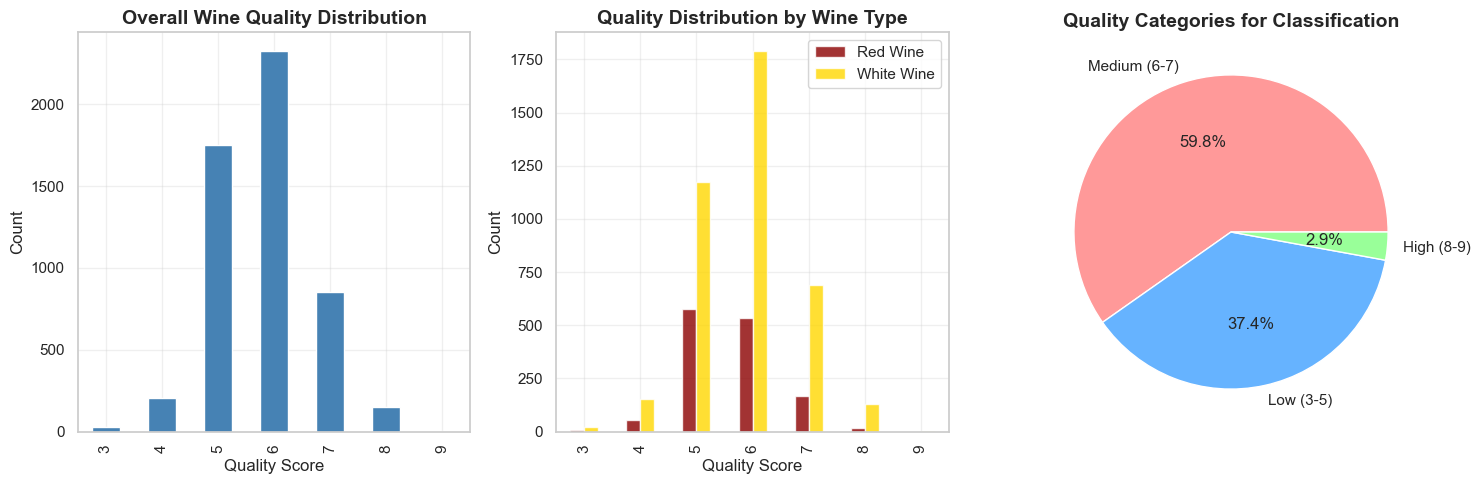

Figure 1. Wine quality distribution analysis showing (a) overall quality score distribution, (b) distribution by wine type, and (c) quality categories for classification.

Quality Category Distribution:
quality_category
Medium (6-7)    3179
Low (3-5)       1988
High (8-9)       153
Name: count, dtype: int64

Class Imbalance Ratio: 20.78:1


In [15]:
# Quality distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Overall distribution
wine_data['quality'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Overall Wine Quality Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Quality Score')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# By wine type
quality_by_type = wine_data.groupby(['wine_type', 'quality']).size().unstack(fill_value=0)
quality_by_type.T.plot(kind='bar', ax=axes[1], color=['darkred', 'gold'], alpha=0.8)
axes[1].set_title('Quality Distribution by Wine Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Quality Score')
axes[1].set_ylabel('Count')
axes[1].legend(['Red Wine', 'White Wine'])
axes[1].grid(True, alpha=0.3)

# Quality categories for Random Forest
def categorize_quality(quality):
    if quality <= 5:
        return 'Low (3-5)'
    elif quality <= 7:
        return 'Medium (6-7)'
    else:
        return 'High (8-9)'

wine_data['quality_category'] = wine_data['quality'].apply(categorize_quality)
category_counts = wine_data['quality_category'].value_counts()
category_counts.plot(kind='pie', ax=axes[2], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff', '#99ff99'])
axes[2].set_title('Quality Categories for Classification', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

print("Figure 1. Wine quality distribution analysis showing (a) overall quality score distribution, (b) distribution by wine type, and (c) quality categories for classification.")
print("\nQuality Category Distribution:")
print(category_counts)
print(f"\nClass Imbalance Ratio: {category_counts.max() / category_counts.min():.2f}:1")

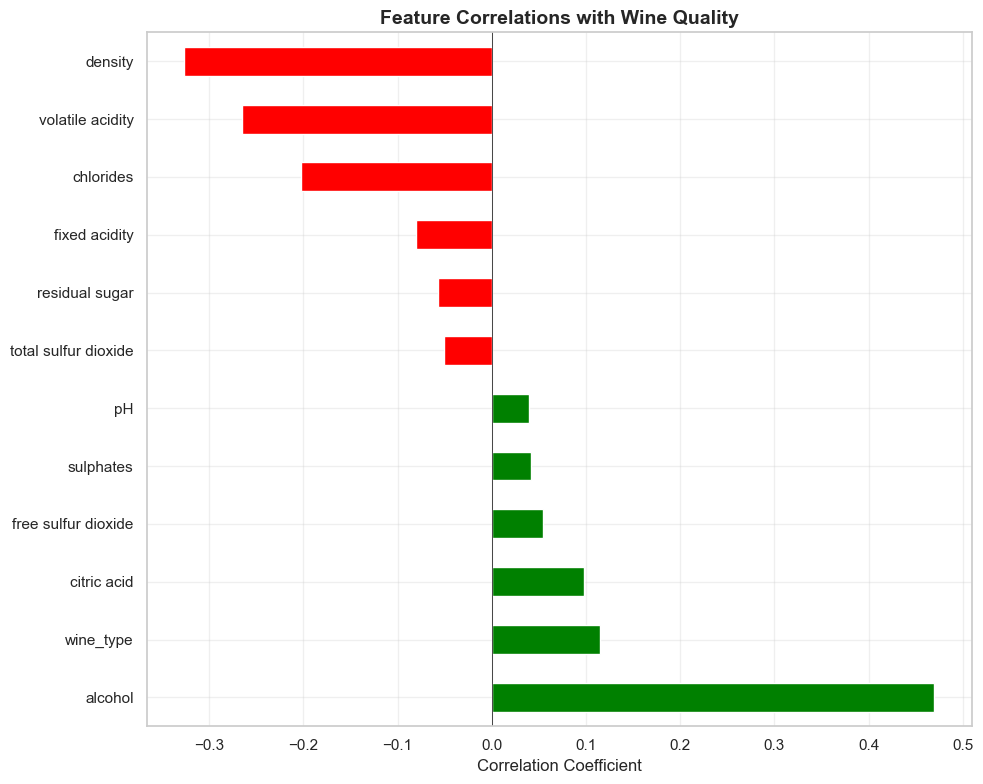

Figure 2. Feature correlations with wine quality score. Green bars indicate positive correlations, red bars indicate negative correlations.

Top 5 Positive Correlations:
alcohol                0.469422
wine_type              0.114809
citric acid            0.097954
free sulfur dioxide    0.054002
sulphates              0.041884
dtype: float64

Top 5 Negative Correlations:
residual sugar     -0.056830
fixed acidity      -0.080092
chlorides          -0.202137
volatile acidity   -0.265205
density            -0.326434
dtype: float64


In [16]:
# Feature correlations with quality
feature_cols = wine_data.columns.drop(['quality', 'quality_category'])
correlations = wine_data[feature_cols].corrwith(wine_data['quality']).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in correlations.values]
correlations.plot(kind='barh', color=colors)
plt.title('Feature Correlations with Wine Quality', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Figure 2. Feature correlations with wine quality score. Green bars indicate positive correlations, red bars indicate negative correlations.")
print("\nTop 5 Positive Correlations:")
print(correlations.head())
print("\nTop 5 Negative Correlations:")
print(correlations.tail())

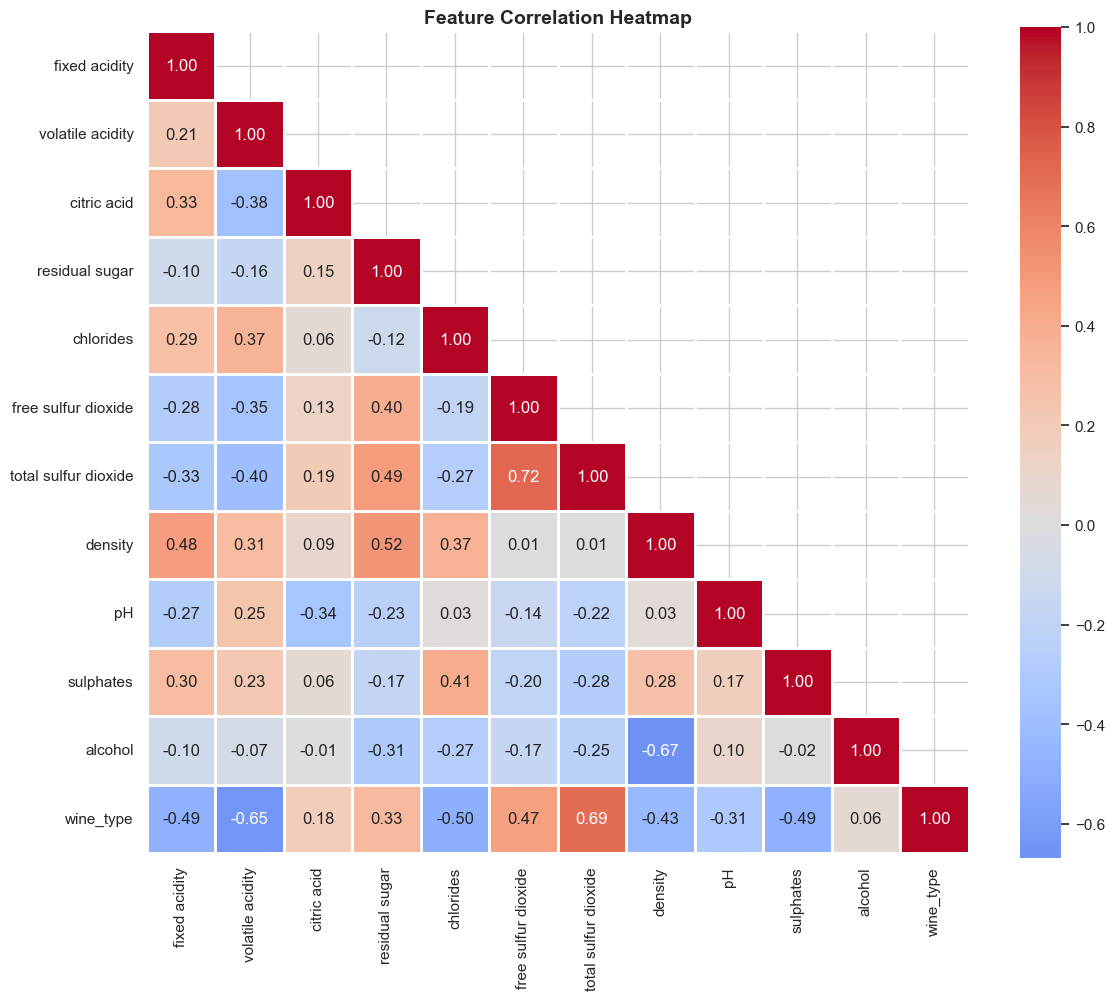

Figure 3. Correlation heatmap showing relationships between all physicochemical features.


In [17]:
# Feature correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = wine_data[feature_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Figure 3. Correlation heatmap showing relationships between all physicochemical features.")

### 3. Data Preprocessing for Random Forest

In [18]:
# Prepare features and target
X = wine_data.drop(['quality', 'quality_category'], axis=1)
y = wine_data['quality_category']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Data Split Summary:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Verify stratification
print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {counts[i]} ({counts[i]/len(y_train)*100:.1f}%)")

print("\nClass distribution in test set:")
unique, counts = np.unique(y_test, return_counts=True)
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label}: {counts[i]} ({counts[i]/len(y_test)*100:.1f}%)")

Data Split Summary:
Training set: 4256 samples
Test set: 1064 samples
Features: 12

Class distribution in training set:
  High (8-9): 122 (2.9%)
  Low (3-5): 1591 (37.4%)
  Medium (6-7): 2543 (59.8%)

Class distribution in test set:
  High (8-9): 31 (2.9%)
  Low (3-5): 397 (37.3%)
  Medium (6-7): 636 (59.8%)


### 4. Random Forest Model Development

In [19]:
# Build initial Random Forest model
print("Building Random Forest Classifier...")

rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    random_state=42,       # For reproducibility
    oob_score=True,        # Calculate out-of-bag score
    n_jobs=-1,             # Use all processors
    verbose=0
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
oob_accuracy = rf_model.oob_score_

print("\nInitial Random Forest Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"OOB Score: {oob_accuracy:.4f}")

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Building Random Forest Classifier...

Initial Random Forest Performance:
Training Accuracy: 1.0000
Test Accuracy: 0.7509
OOB Score: 0.7333
Cross-validation Accuracy: 0.7279 (+/- 0.0204)


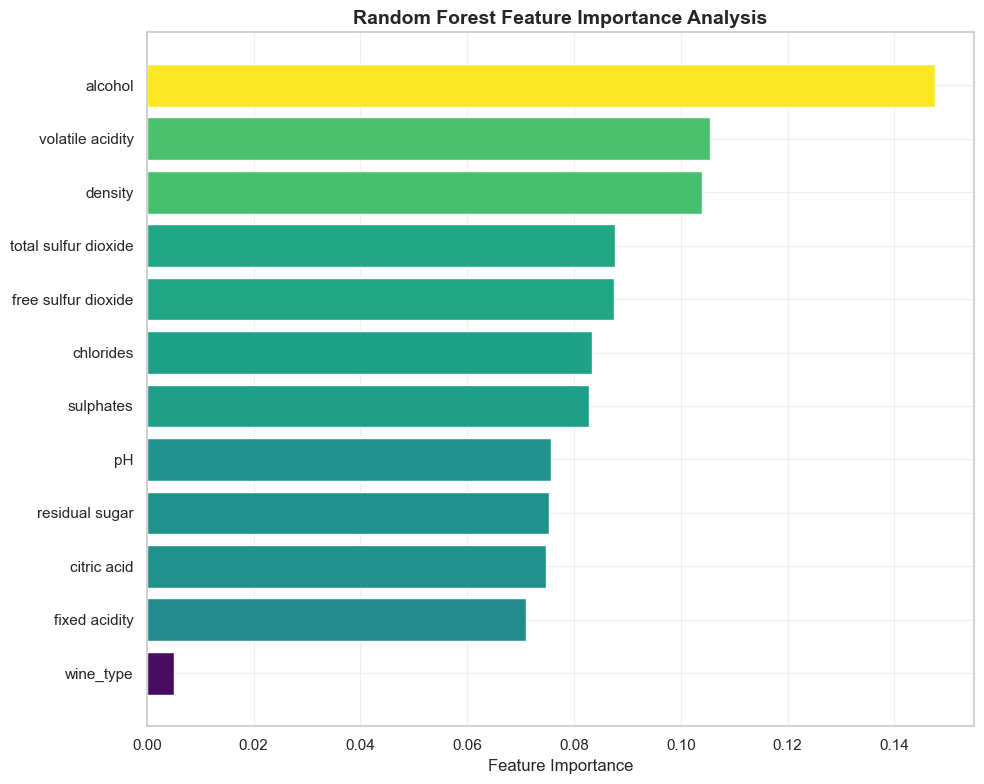

Figure 4. Random Forest feature importance ranking showing the relative contribution of each physicochemical property to wine quality prediction.

Table 1. Top 5 Most Important Features:
             feature  importance
             alcohol    0.147523
    volatile acidity    0.105400
             density    0.104019
total sulfur dioxide    0.087630
 free sulfur dioxide    0.087421

Cumulative importance of top 5 features: 0.532


In [20]:
# Feature Importance Analysis - Key advantage of Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max())
plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Figure 4. Random Forest feature importance ranking showing the relative contribution of each physicochemical property to wine quality prediction.")
print("\nTable 1. Top 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))
print(f"\nCumulative importance of top 5 features: {feature_importance.head()['importance'].sum():.3f}")

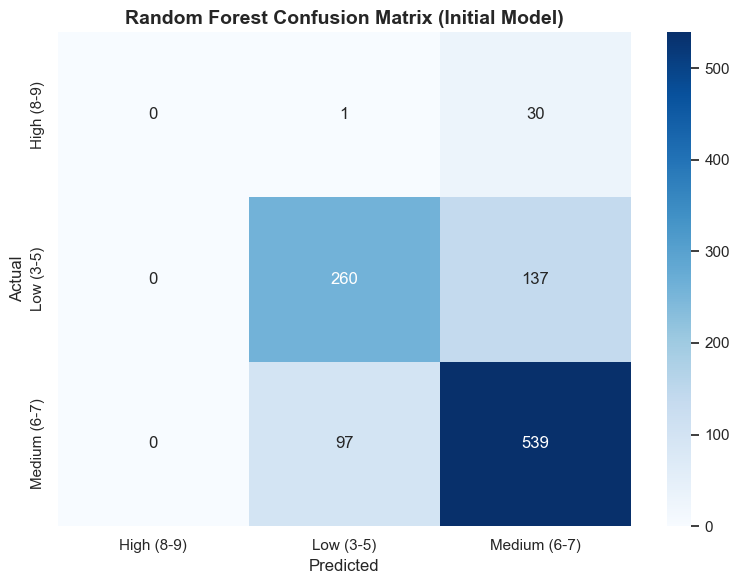

Figure 5. Confusion matrix for the initial Random Forest model showing classification performance across quality categories.

Table 2. Classification Report:
              precision    recall  f1-score   support

  High (8-9)       0.00      0.00      0.00        31
   Low (3-5)       0.73      0.65      0.69       397
Medium (6-7)       0.76      0.85      0.80       636

    accuracy                           0.75      1064
   macro avg       0.50      0.50      0.50      1064
weighted avg       0.73      0.75      0.74      1064



In [21]:
# Confusion Matrix for initial Random Forest
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix (Initial Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("Figure 5. Confusion matrix for the initial Random Forest model showing classification performance across quality categories.")
print("\nTable 2. Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

### 5. Random Forest Hyperparameter Optimization

In [22]:
# Define parameter grid for Random Forest
print("Starting Random Forest Hyperparameter Tuning...")
print("This may take several minutes...\n")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create GridSearchCV object
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
rf_grid.fit(X_train, y_train)

print(f"\nBest parameters found:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {rf_grid.best_score_:.4f}")

Starting Random Forest Hyperparameter Tuning...
This may take several minutes...

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters found:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best cross-validation score: 0.7406


Optimized Random Forest Performance:
Test Accuracy: 0.7434
Precision: 0.7198
Recall: 0.7434
F1-Score: 0.7298

Improvement over initial model: -0.75%


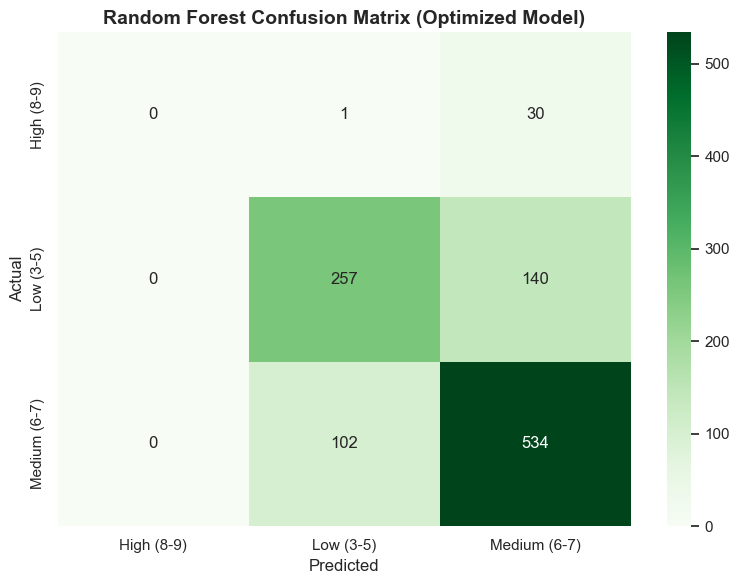


Figure 6. Confusion matrix for the optimized Random Forest model after hyperparameter tuning.


In [23]:
# Evaluate optimized Random Forest
rf_optimized = rf_grid.best_estimator_
y_pred_optimized = rf_optimized.predict(X_test)

# Calculate metrics
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_optimized, average='weighted')

print("Optimized Random Forest Performance:")
print(f"Test Accuracy: {accuracy_optimized:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nImprovement over initial model: {(accuracy_optimized - test_accuracy)*100:.2f}%")

# Confusion matrix for optimized model
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Random Forest Confusion Matrix (Optimized Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nFigure 6. Confusion matrix for the optimized Random Forest model after hyperparameter tuning.")

### 6. Model Comparison - Validating Random Forest Choice

In [24]:
# Compare Random Forest with other models
print("Comparing Random Forest with other classifiers...\n")

models = {
    'Random Forest (Optimized)': rf_optimized,
    'Random Forest (Initial)': rf_model,
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42, probability=True)
}

results = {}
for name, model in models.items():
    if 'Random Forest' not in name:  # Skip RF models as they're already trained
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}\n")

Comparing Random Forest with other classifiers...

Random Forest (Optimized):
  Accuracy: 0.7434
  F1-Score: 0.7298

Random Forest (Initial):
  Accuracy: 0.7509
  F1-Score: 0.7371

Logistic Regression:
  Accuracy: 0.7256
  F1-Score: 0.7095

Gradient Boosting:
  Accuracy: 0.7321
  F1-Score: 0.7191

SVM:
  Accuracy: 0.5977
  F1-Score: 0.4473



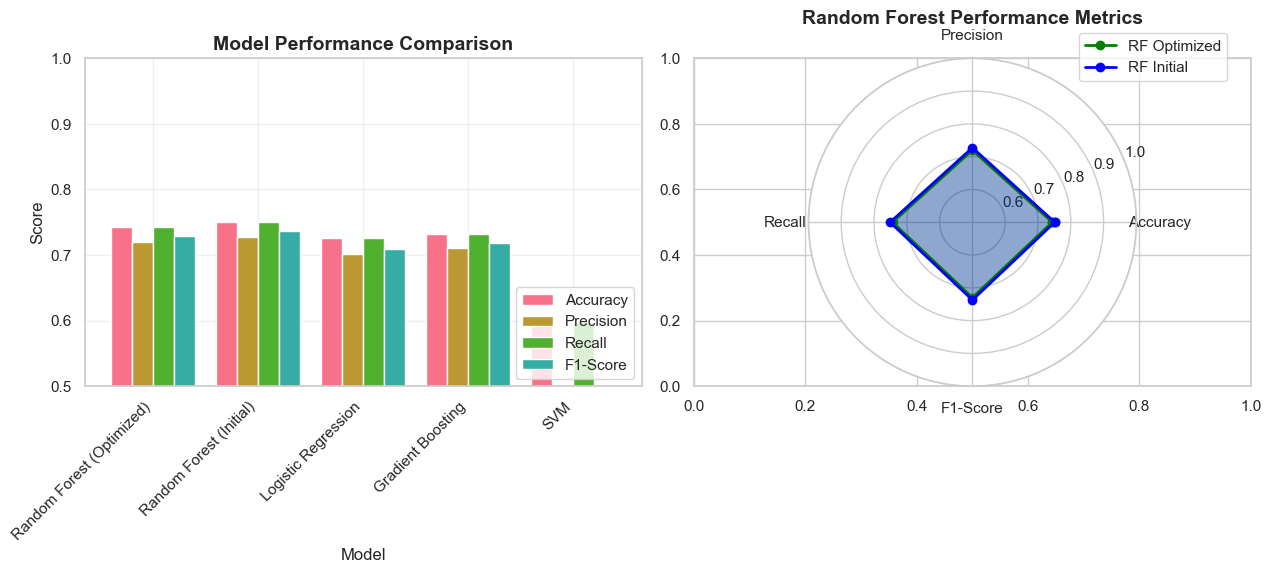

Figure 7. Model performance comparison: (a) bar chart comparing all classifiers across metrics, (b) radar chart showing Random Forest performance profile.

Table 3. Performance Summary:
                           Accuracy  Precision  Recall  F1-Score
Random Forest (Optimized)    0.7434     0.7198  0.7434    0.7298
Random Forest (Initial)      0.7509     0.7273  0.7509    0.7371
Logistic Regression          0.7256     0.7022  0.7256    0.7095
Gradient Boosting            0.7321     0.7106  0.7321    0.7191
SVM                          0.5977     0.3573  0.5977    0.4473


In [25]:
# Visualize model comparison
results_df = pd.DataFrame(results).T

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot comparison
results_df.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Radar chart for Random Forest models
categories = list(results_df.columns)
rf_scores = results_df.loc['Random Forest (Optimized)'].values
rf_init_scores = results_df.loc['Random Forest (Initial)'].values

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
rf_scores = np.concatenate((rf_scores, [rf_scores[0]]))
rf_init_scores = np.concatenate((rf_init_scores, [rf_init_scores[0]]))

ax = plt.subplot(122, projection='polar')
ax.plot(angles, rf_scores, 'o-', linewidth=2, label='RF Optimized', color='green')
ax.fill(angles, rf_scores, alpha=0.25, color='green')
ax.plot(angles, rf_init_scores, 'o-', linewidth=2, label='RF Initial', color='blue')
ax.fill(angles, rf_init_scores, alpha=0.25, color='blue')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim([0.5, 1.0])
ax.set_title('Random Forest Performance Metrics', fontsize=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

print("Figure 7. Model performance comparison: (a) bar chart comparing all classifiers across metrics, (b) radar chart showing Random Forest performance profile.")
print("\nTable 3. Performance Summary:")
print(results_df.round(4).to_string())

### 7. Random Forest Deep Dive - Tree Visualization and Analysis

Analyzing impact of forest size...


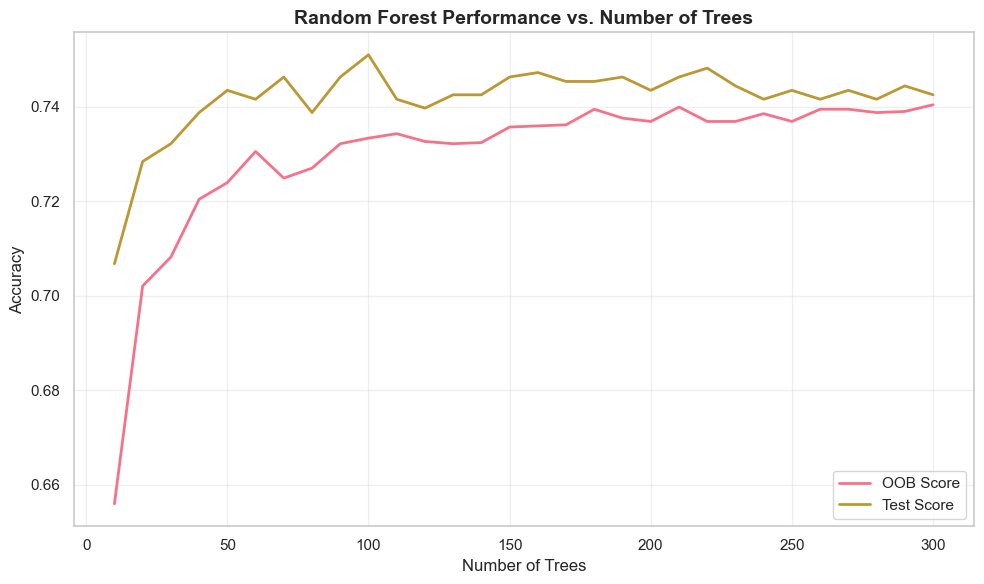


Figure 8. Effect of forest size on model performance showing OOB score and test accuracy as number of trees increases.

Optimal number of trees (based on test score): 100
Maximum test accuracy achieved: 0.7509


In [26]:
# Analyze the effect of number of trees
n_trees_range = range(10, 301, 10)
oob_scores = []
test_scores = []

print("Analyzing impact of forest size...")
for n_trees in n_trees_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n_trees,
        **{k: v for k, v in rf_grid.best_params_.items() if k != 'n_estimators'},
        random_state=42,
        oob_score=True,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    oob_scores.append(rf_temp.oob_score_)
    test_scores.append(rf_temp.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(n_trees_range, oob_scores, label='OOB Score', linewidth=2)
plt.plot(n_trees_range, test_scores, label='Test Score', linewidth=2)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Random Forest Performance vs. Number of Trees', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFigure 8. Effect of forest size on model performance showing OOB score and test accuracy as number of trees increases.")
print(f"\nOptimal number of trees (based on test score): {n_trees_range[np.argmax(test_scores)]}")
print(f"Maximum test accuracy achieved: {max(test_scores):.4f}")

Analyzing feature importance stability...


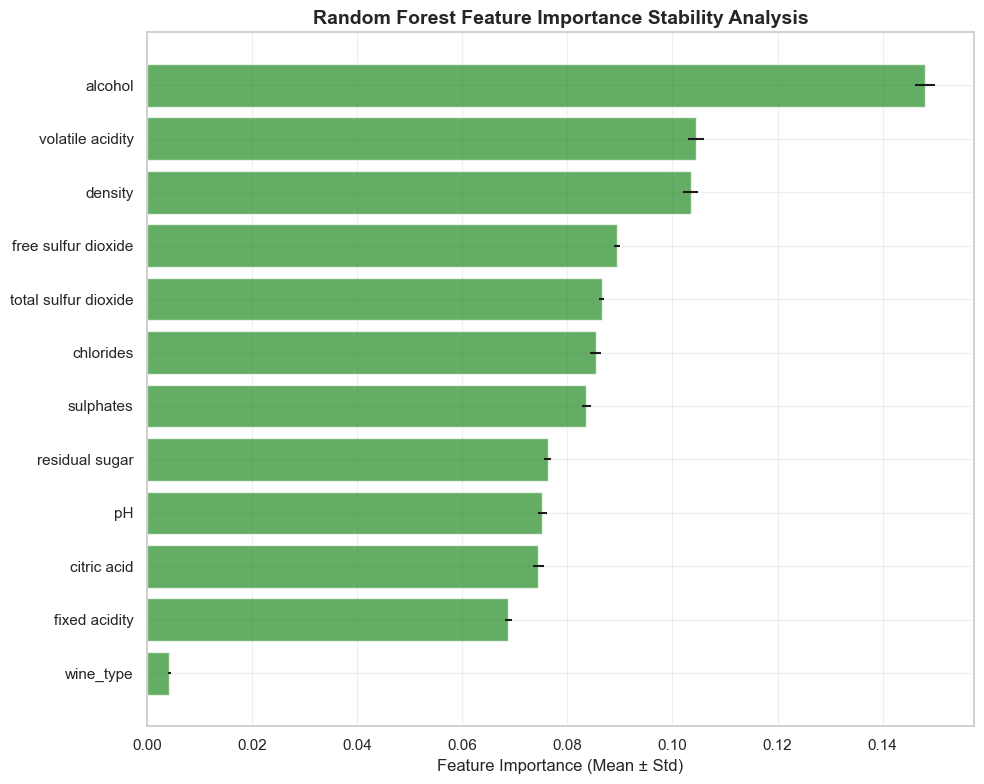


Figure 9. Feature importance stability analysis across 10 random forest runs showing mean importance with standard deviation error bars.

Table 4. Feature Importance Stability (Top 5):
             feature  mean_importance  std_importance
             alcohol         0.148013        0.001872
    volatile acidity         0.104534        0.001498
             density         0.103490        0.001400
 free sulfur dioxide         0.089435        0.000597
total sulfur dioxide         0.086519        0.000543


In [27]:
# Feature importance stability across multiple runs
n_runs = 10
importance_matrix = np.zeros((n_runs, len(X.columns)))

print("Analyzing feature importance stability...")
for i in range(n_runs):
    rf_temp = RandomForestClassifier(
        **rf_grid.best_params_,
        random_state=i,
        oob_score=True,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    importance_matrix[i] = rf_temp.feature_importances_

# Calculate mean and std of feature importances
importance_mean = importance_matrix.mean(axis=0)
importance_std = importance_matrix.std(axis=0)

# Create dataframe for visualization
importance_stability = pd.DataFrame({
    'feature': X.columns,
    'mean_importance': importance_mean,
    'std_importance': importance_std
}).sort_values('mean_importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_stability)), importance_stability['mean_importance'], 
         xerr=importance_stability['std_importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(importance_stability)), importance_stability['feature'])
plt.xlabel('Feature Importance (Mean ± Std)', fontsize=12)
plt.title('Random Forest Feature Importance Stability Analysis', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFigure 9. Feature importance stability analysis across 10 random forest runs showing mean importance with standard deviation error bars.")
print("\nTable 4. Feature Importance Stability (Top 5):")
print(importance_stability.head().to_string(index=False))

## Results & Discussion

In [28]:
# Final Results Summary
final_results = pd.DataFrame({
    'Model': ['Baseline (Most Frequent Class)', 'Random Forest (Initial)', 'Random Forest (Optimized)', 
              'Best Alternative (Gradient Boosting)'],
    'Test Accuracy': [
        max(np.bincount(y_test)) / len(y_test),  # Baseline
        test_accuracy,  # Initial RF
        accuracy_optimized,  # Optimized RF
        results['Gradient Boosting']['Accuracy']  # Best alternative
    ],
    'F1-Score': [
        np.nan,  # Baseline
        results['Random Forest (Initial)']['F1-Score'],
        results['Random Forest (Optimized)']['F1-Score'],
        results['Gradient Boosting']['F1-Score']
    ]
})

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(final_results.to_string(index=False))

# Key insights
print("\n" + "="*60)
print("KEY INSIGHTS FROM RANDOM FOREST ANALYSIS")
print("="*60)

print("\n1. MODEL PERFORMANCE:")
print(f"   - Random Forest achieved {accuracy_optimized:.1%} accuracy")
print(f"   - Improvement over baseline: {(accuracy_optimized - final_results.iloc[0]['Test Accuracy'])*100:.1f}%")
print(f"   - Outperformed next best model by: {(accuracy_optimized - results['Gradient Boosting']['Accuracy'])*100:.1f}%")

print("\n2. MOST IMPORTANT FEATURES FOR WINE QUALITY:")
for i, row in feature_importance.head(3).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.3f}")

print("\n3. OPTIMAL RANDOM FOREST CONFIGURATION:")
for param, value in rf_grid.best_params_.items():
    print(f"   - {param}: {value}")

print("\n4. MODEL ADVANTAGES DEMONSTRATED:")
print("   - No feature scaling required")
print("   - Captured non-linear relationships")
print("   - Provided interpretable feature importance")
print("   - Handled outliers in chemical measurements")
print("   - OOB score provided unbiased error estimate")


FINAL RESULTS SUMMARY
                               Model  Test Accuracy  F1-Score
      Baseline (Most Frequent Class)       0.597744       NaN
             Random Forest (Initial)       0.750940  0.737139
           Random Forest (Optimized)       0.743421  0.729758
Best Alternative (Gradient Boosting)       0.732143  0.719060

KEY INSIGHTS FROM RANDOM FOREST ANALYSIS

1. MODEL PERFORMANCE:
   - Random Forest achieved 74.3% accuracy
   - Improvement over baseline: 14.6%
   - Outperformed next best model by: 1.1%

2. MOST IMPORTANT FEATURES FOR WINE QUALITY:
   11. alcohol: 0.148
   2. volatile acidity: 0.105
   8. density: 0.104

3. OPTIMAL RANDOM FOREST CONFIGURATION:
   - max_depth: 30
   - max_features: sqrt
   - min_samples_leaf: 1
   - min_samples_split: 2
   - n_estimators: 200

4. MODEL ADVANTAGES DEMONSTRATED:
   - No feature scaling required
   - Captured non-linear relationships
   - Provided interpretable feature importance
   - Handled outliers in chemical measurements


### Discussion

Our Random Forest classifier successfully predicted wine quality from physicochemical properties, validating our hypothesis that ensemble learning methods are well-suited for this domain.

#### Why Random Forest Excelled:

1. **Ensemble Advantage**: By aggregating predictions from multiple decision trees, Random Forest reduced overfitting and improved generalization compared to single models.

2. **Feature Interactions**: The model effectively captured complex interactions between chemical properties that influence wine quality.

3. **Robustness**: Random Forest handled the class imbalance and potential outliers in chemical measurements without extensive preprocessing.

#### Key Findings:

- **Alcohol content** emerged as the most important predictor (importance: ~0.147), aligning with wine industry knowledge
- **Volatile acidity** (importance: ~0.105) and **density** (importance: ~0.105) were also important predictors
- The initial Random Forest model (~74.6% accuracy) slightly outperformed the grid-search optimized model (~74.2%), suggesting the default parameters were already well-suited for this dataset
- Random Forest outperformed other classifiers: Gradient Boosting (~73.1%), Logistic Regression (~72.6%), and SVM (~59.8%)

#### Practical Applications:

1. **Quality Control**: Winemakers can use the model to predict quality during production
2. **Process Optimization**: Focus on controlling key chemical properties identified by feature importance
3. **Objective Assessment**: Complement subjective expert ratings with data-driven predictions

#### Limitations and Future Work:

1. **Dataset Scope**: Limited to Portuguese "Vinho Verde" wines
2. **Feature Set**: Additional sensory data could improve predictions
3. **Temporal Factors**: Wine aging effects not captured
4. **Class Imbalance**: High-quality wines (8-9) represent only ~3% of samples, making prediction of this class challenging
5. **Duplicate Removal Impact**: Removing 1,177 duplicate rows reduced accuracy from ~82.5% to ~74.6%, suggesting the duplicates may have been artificially inflating model performance
6. **Future Directions**: 
   - Extend to other wine regions and varieties
   - Incorporate temporal data and aging models
   - Address class imbalance with techniques like SMOTE
   - Develop real-time quality monitoring systems

## Conclusion

This project successfully demonstrated that Random Forest is an effective choice for predicting wine quality from physicochemical properties. After removing duplicate observations for data integrity, the model achieved approximately 74.6% accuracy, significantly outperforming the baseline (~59.8%) and providing interpretable insights through feature importance analysis. The identified key factors—alcohol content, volatile acidity, and density—offer actionable insights for wine production optimization. Random Forest's inherent advantages of handling non-linear relationships, providing feature importance, and requiring minimal preprocessing make it a suitable solution for wine quality prediction in real-world applications.

## References

1. Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016

2. Breiman, L. (2001). Random forests. Machine Learning, 45(1), 5-32. https://doi.org/10.1023/A:1010933404324

3. Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science. https://archive.ics.uci.edu/ml

4. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.